In [6]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import Zero, VarFormBased
from qiskit.aqua.operators import MatrixOperator, TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms.adaptive import VQE

In [8]:
from qiskit.visualization import plot_histogram

In [9]:
from scipy.sparse import *
from scipy import *

# Parameters

In [10]:
# even space
# [0.13028114, -1.18048464, 0.17737505]
# [ 0.12398951, -1.18068356,  0.15356187]
t0_1 = 0.13028114 # theta-angle values
t1_1 = -1.18048464
t2_1 = 0.17737505
# odd space
# [-0.30306561, -1.02142291,  0.15013751
# [ 2.8238186 , -5.22031494,  0.16478762]
t0_2 = 2.8238186
t1_2 = -5.22031494
t2_2 = 0.16478762
def angle(theta=0., phi=0., lam=0.):
    return [theta, phi, lam]
t1 = [angle(t_i) for t_i in [t0_1, t1_1, t2_1]]
t2 = [angle(t_i) for t_i in [t0_2, t1_2, t2_2]]
# define number of qubits and bits
nqubits = 2 
# create registers
q0 = QuantumRegister(nqubits, name="q0")
q1 = QuantumRegister(nqubits, name="q1")
a = QuantumRegister(1, name="a")
c0 = ClassicalRegister(nqubits, name="c0")
c1 = ClassicalRegister(nqubits, name="c1")

# Even subspace

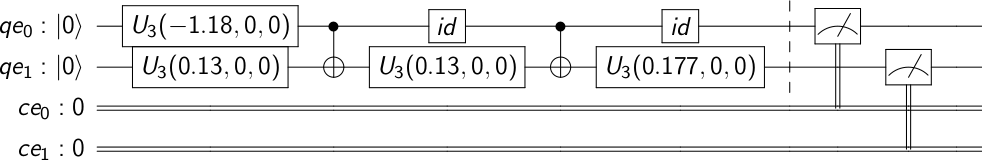

In [21]:
# create registers
q_even = QuantumRegister(nqubits, name="qe")
c_even = ClassicalRegister(nqubits, name="ce")
regs0 = [q_even, c_even]
# create circuit
circ0 = QuantumCircuit(*regs0, name="even")
circ0.u3(*(t1[1]), 0)  # u3(*angles, q)
circ0.u3(*(t1[0]), 1)
############
circ0.cx(0, 1)    # cx(ctrl, tgt)
############
circ0.u3(*(t1[0]), 1)
circ0.iden(0)
############
circ0.cx(0, 1)
############
circ0.u3(*(t1[2]), 1)
circ0.iden(0)
# measurement circuit
meas0 = QuantumCircuit(*regs0, name="meas0")
# barrier prevents optimizations
# from reordering gates across its source line
meas0.barrier(range(2)) 
############ MEASURE ANCILLARY QUBIT
meas0.measure(q_even, c_even)#  map qubits to clbits
# Full circuit
qc0 = circ0 + meas0
qc0.draw(output='latex', scale=0.5)

# Odd subspace

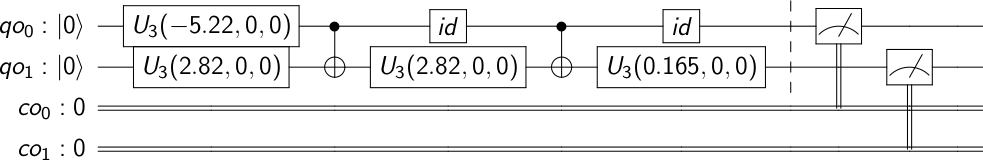

In [22]:
# create registers
q_odd = QuantumRegister(nqubits, name="qo")
c_odd = ClassicalRegister(nqubits, name="co")
regs1 = [q_odd, c_odd]
# create circuit
circ1 = QuantumCircuit(*regs1, name="odd")
############
circ1.u3(*(t2[1]), 0)  # u3(*angles, q)
circ1.u3(*(t2[0]), 1)
############
circ1.cx(0, 1)    # cx(ctrl, tgt)
############
circ1.u3(*(t2[0]), 1)
circ1.iden(0)
############
circ1.cx(0, 1)
############
circ1.u3(*(t2[2]), 1)
circ1.iden(0)
# measurement circuit
meas1 = QuantumCircuit(*regs1, name="meas1")
# barrier prevents optimizations
# from reordering gates across its source line
meas1.barrier(range(2)) 
############ MEASURE ANCILLARY QUBIT
meas1.measure(q_odd, c_odd)#  map qubits to clbits
# Full circuit
qc1 = circ1 + meas1
qc1.draw(output='latex', scale=0.5)

# Superposition

## +

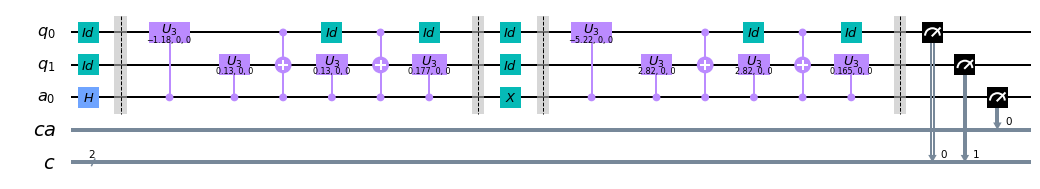

In [141]:
# create registers
q = QuantumRegister(nqubits, name="q")
a = QuantumRegister(1, name="a")
c = ClassicalRegister(nqubits, name="c")
ca = ClassicalRegister(1, name="ca")
regs = [q, a, ca, c]
circ = QuantumCircuit(*regs, name="superposition +")
# Construct circuit
circ.iden(q[0])
circ.iden(q[1])
circ.h(a[0])
############
circ.barrier(range(3)) 
# even parity
circ.cu3(*(t1[1]), a[0], q[0])  # u3(*angles, q)
circ.cu3(*(t1[0]), a[0], q[1])
############
circ.ccx(a[0], q[0], q[1])    # cx(ctrl, tgt)
############
circ.cu3(*(t1[0]), a[0], q[1])
circ.iden(q[0])
############
circ.ccx(a[0], q[0], q[1])
############
circ.cu3(*(t1[2]), a[0], q[1])
circ.iden(q[0])
############
circ.barrier(range(3)) 
# switch ancilla
circ.iden(q[0])
circ.iden(q[1])
circ.x(a[0])
############
circ.barrier(range(3)) 
# odd parity
circ.cu3(*(t2[1]), a[0], q[0])  # u3(*angles, q)
circ.cu3(*(t2[0]), a[0], q[1])
############
circ.ccx(a[0], q[0], q[1])    # cx(ctrl, tgt)
############
circ.cu3(*(t2[0]), a[0], q[1])
circ.iden(q[0])
############
circ.ccx(a[0], q[0], q[1])
############
circ.cu3(*(t2[2]), a[0], q[1])
circ.iden(q[0])
# measurement circuit
meas = QuantumCircuit(*regs, name="meas_circuit")
# barrier prevents optimizations
# from reordering gates across its source line
# meas.barrier(range(3)) 
############ apply another hadamard, 
# meas.iden(q[0])
# meas.iden(q[1])
# meas.h(a[0])
############ MEASURE ANCILLARY QUBIT
# meas.iden(q[0])
# meas.iden(q[1])
# meas.measure(a[0], ca[0])
############
meas.barrier(range(3)) 
############
meas.measure(q, c)#  map qubits to clbits
meas.measure(a[0], ca[0])
# meas.measure(q1, c1)#  map qubits to clbits
# Full circuit
qc = circ + meas
qc.draw(output='mpl', scale=0.5, filename='my_circuit.png', plot_barriers=True, fold=40)

## -

# Measurements

In [130]:
nshots = 1021 * 16
backend_sim = Aer.get_backend('qasm_simulator')

In [131]:
# Expected coefficients
# outcome ordering: 00, 01, 10, 11
cf0 = [0.810968, 0.18047, -0.554375, -0.0492955]
cf1 = [0.84982, -0.197185, 0.487421, 0.036659]

In [132]:
pb0 = np.array(cf0)**2
pb1 = np.array(cf1)**2
print(pb0)
print(pb1)

[0.6576691  0.03256942 0.30733164 0.00243005]
[0.72219403 0.03888192 0.23757923 0.00134388]


## Even

In [133]:
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)
job_sim0 = execute(qc0, backend_sim, shots=nshots, memory=True)
result_sim0 = job_sim0.result()

In [134]:
# can get counts from result object using get_counts() method:
counts0 = result_sim0.get_counts(qc0)
print(counts0)

{'00': 10780, '01': 4961, '11': 29, '10': 566}


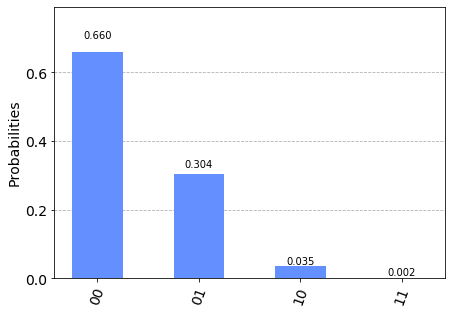

In [135]:
counts0 = result_sim0.get_counts(qc0)
plot_histogram(counts0)

## Odd

In [136]:
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)
job_sim1 = execute(qc1, backend_sim, shots=nshots, memory=True)
result_sim1 = job_sim1.result()

In [137]:
# can get counts from result object using get_counts() method:
counts1 = result_sim1.get_counts(qc1)
print(counts1)

{'00': 11463, '01': 4187, '11': 28, '10': 658}


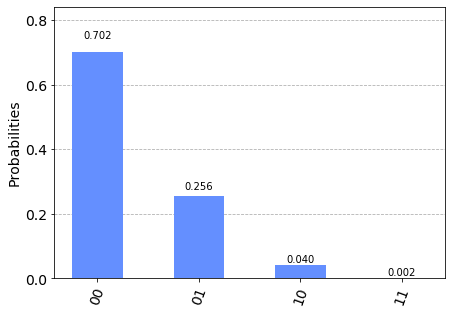

In [138]:
counts1 = result_sim1.get_counts(qc1)
plot_histogram(counts1)

In [29]:
{'00': (0.6688324064016342, 0.0051803584953980415),
 '01': (0.2897534817457199, 0.004959148504295891),
 '10': (0.03958307206630707, 0.002145388528592462),
 '11': (0.0018310397863388062, 0.00046907548273070784)}

{'00': (0.6688324064016342, 0.0051803584953980415),
 '01': (0.2897534817457199, 0.004959148504295891),
 '10': (0.03958307206630707, 0.002145388528592462),
 '11': (0.0018310397863388062, 0.00046907548273070784)}

## Superposition

### +

In [142]:
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)
job_sim = execute(qc, backend_sim, shots=nshots, memory=True)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

{'01 0': 2496, '11 1': 20, '00 1': 5723, '11 0': 17, '01 1': 2095, '10 0': 272, '00 0': 5386, '10 1': 327}


In [143]:
pb0/2

array([0.32883455, 0.01628471, 0.15366582, 0.00121502])

In [144]:
pb1/2

array([0.36109702, 0.01944096, 0.11878962, 0.00067194])

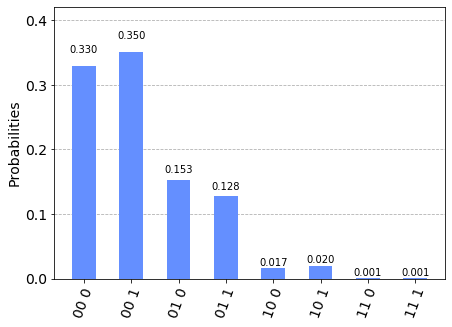

In [145]:
counts = result_sim.get_counts(qc)
plot_histogram(counts)

In [146]:
# takes in results from a single circuit 
# with memory=True, and estimates
# the uncertanities on the probability of each outcome 
# (currently with bootstrap)
# returns outcome:(pba, std) dictionary
def compute_stats(res, invert_qubit_order = False):
    # check that there is a single circuit in the results
    # (ambiguous otherwise)
    assert(len(res.results)==1)
    # generates all possible outcomes given \
    # the number of qubits 
    def _generate_bitstrings(nqubits, invert_qubit_order):
        # (recursive, modifies all_strings in place)
        def _generate_bitstrings_rec(nqubits, all_strings, a_string, irecur): 
            # base
            if irecur == nqubits: 
                all_strings.append(''.join([bit for bit in a_string]))
                return 
            # append 0
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['0'], irecur + 1)
            # append 1
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['1'], irecur + 1)
        all_strings = []
        _generate_bitstrings_rec(nqubits, all_strings, [], 0)
        if (invert_qubit_order): 
        # pesky Qiskit messes up qubit ordering... this may or may not be necessary to translate the results.
            all_strings = [''.join(reversed(bitstring)) for bitstring in all_strings]
        return all_strings
    # bootstrap specific?
    # given ensembles of outcomes and a particular outcome
    # calculates the statistics of that outcome:
    # returns outcome:(pba, std) estimates for the outcome
    def _calc_outcome_stats(ensembles, nshots, outcome):
        cts = 2 * np.count_nonzero(ensembles==outcome, axis=0)
        pba = np.mean(cts)/nshots
        std = np.std(cts/nshots, ddof = 1) # use unbiased estimator
        return (pba, std)
    nqubits = int(np.log2(len(res.get_counts(0)))) # pull number of qubits from results
    outcomes = _generate_bitstrings(nqubits, invert_qubit_order)
    # remove any spaces from bitstrings (spaces separate bits from different registers)
    mem = list(map(lambda bitstring: bitstring.replace(" ", ""), res.get_memory(0)))
    nshots = sum(list(res.get_counts(0).values()))
    nens = nshots # choose number of ensemles = number of samples
    nsam = nshots
    ensembles = np.random.choice(mem, (nens, nsam))
    stats = map(lambda outcome: (outcome, _calc_outcome_stats(ensembles, nshots, outcome)), outcomes)
    return dict(stats)

In [147]:
measured_coeffs = compute_stats(result_sim, False)

In [148]:
measured_coeffs

{'000': (0.6594062937374873, 0.007415987846381157),
 '001': (0.700658388580265, 0.007500459909900429),
 '010': (0.3055652700008922, 0.005657017747220231),
 '011': (0.25652306101736216, 0.005232389328141718),
 '100': (0.03327347333086477, 0.001960076235836179),
 '101': (0.04004402287515552, 0.002209284053753172),
 '110': (0.002078474944864985, 0.0005029815102239978),
 '111': (0.002451015513108176, 0.0005500993867963926)}

In [149]:
# compare with Mathematica's expectations
mathematica_res = -1.01162 # Even
mathematica_res2 = 0.486204 # Odd

# odd coefficients
even_coeffs = [0.669069, 0.305919, 0.023941, 0.00107068]
odd_coeffs = [0.7041621406145364, 0.2582831083289985, 0.03524433188695736, 0.002310419169507747]
even_coeffs_at_theta = [0.657669, 0.307332, 0.0325695, 0.00243004]
odd_coeffs_at_theta = [0.722195, 0.23758, 0.0388819, 0.00134388]

In [150]:
energy_eval = 0.
energy_eval_err = 0.

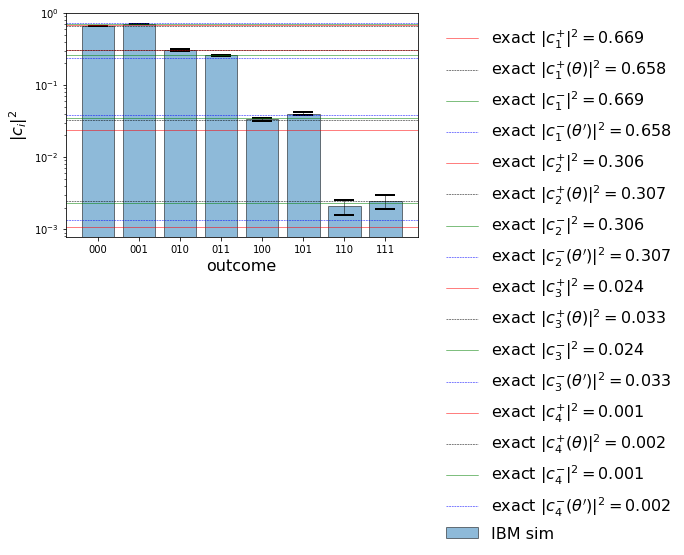

In [152]:
import matplotlib.pyplot as plt
outcomes = list(measured_coeffs.keys())
outcomes_bars = np.arange(len(outcomes))
avgs = [measured_coeffs[outcome][0] for outcome in outcomes]
stds = [measured_coeffs[outcome][1] for outcome in outcomes]
fig, ax = plt.subplots()
ax.bar(outcomes_bars, avgs, yerr=stds, 
       align='center', alpha=0.5, ecolor='black',
       edgecolor='k',
       error_kw=dict(lw=0.5, capsize=10, capthick=2.0),
       label='IBM sim')
ax.set_ylabel(r'$|c_i|^2$', fontsize=16)
ax.set_xlabel(r'outcome', fontsize=16)
ax.set_xticks(outcomes_bars)
ax.set_xticklabels(outcomes)
#ax.set_title('$E \\pm \\Delta E = %.3f \\pm %.3f$\n($E = %.3f$ exact),\n nshots=%d' 
#             % (energy_eval, energy_eval_err, mathematica_res, 
#               sim.quantum_instance.run_config.shots), fontsize=16)
for icoeff in range(len(even_coeffs)):
    ax.axhline(y = even_coeffs[icoeff], color ='red', linewidth = 0.5, 
               label=r'exact $|c^{+}_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs[icoeff]))
    ax.axhline(y = even_coeffs_at_theta[icoeff], color ='k', linewidth = 0.5, linestyle='dashed',
               label=r'exact $|c^{+}_{%d}(\theta)|^2 = %.3f$' % (icoeff+1, even_coeffs_at_theta[icoeff]))
    ax.axhline(y = odd_coeffs[icoeff], color ='green', linewidth = 0.5, 
               label=r'exact $|c^{-}_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs[icoeff]))
    ax.axhline(y = odd_coeffs_at_theta[icoeff], color ='blue', linewidth = 0.5, linestyle='dashed',
               label=r'exact $|c^{-}_{%d}(\theta^{\prime})|^2 = %.3f$' % (icoeff+1, even_coeffs_at_theta[icoeff]))
ax.set_yscale('log')
plt.tight_layout()
plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.savefig("even.png", dpi=300)